# Modelo para apuestas Premier League

- El predictor está basado en el Pi rating
- Primero cargamos en dataframes los datos de la temporada actual y la anterior, se usa  
  la temporada anterior para calcular los elos iniciales de la actual.

In [8]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import pandasql as pdsql
import matplotlib.pyplot as plt
import sys
import math
import seaborn as sns


# current_season: str = f"{sys.argv[1]}-{int(sys.argv[2]) - 2000}"
# last_season: str = f"{int(sys.argv[1]) - 1:02d}-{int(sys.argv[1]) - 2000:02d}"

first_season: str = "2018-19"
last_season: str = "2023-24"


full_df: pd.DataFrame = pd.DataFrame()
for season in range(int(first_season[:4]), int(last_season[:4]) + 1):
    season_str: str = f"{season:02d}-{season + 1 - 2000:02d}"
    season_df: pd.DataFrame = pd.read_csv(f"Datasets/the_championship/{season_str}.csv")
    season_df["Season"] = season_str
    full_df = pd.concat([full_df, season_df])
full_df.reset_index(drop=True, inplace=True)
full_df.head(20)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E1,03/08/2018,Reading,Derby,1,2,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E1,04/08/2018,Birmingham,Norwich,2,2,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E1,04/08/2018,Brentford,Rotherham,5,1,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E1,04/08/2018,Bristol City,Nott'm Forest,1,1,D,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E1,04/08/2018,Ipswich,Blackburn,2,2,D,1.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,E1,04/08/2018,Millwall,Middlesbrough,2,2,D,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,E1,04/08/2018,Preston,QPR,1,0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,E1,04/08/2018,Sheffield United,Swansea,1,2,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,E1,04/08/2018,West Brom,Bolton,1,2,A,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,E1,04/08/2018,Wigan,Sheffield Weds,3,2,H,2.0,1.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Definimos funciones  para manipular rating.

In [9]:
LOG_BASE: int = 10
ERROR_CONSTANT: int = 3
HOME_PERFORMANCE_LEARNING_RATE: int = 0.5 # \gamma
GOAL_PERFORMANCE_LEARNING_RATE: int = 0.035 # \lambda

def get_new_pi_rating(rating_H_H: int, rating_H_A: int, rating_A_H: int, rating_A_A: int, score_H: int, score_A: int) -> Tuple[int, int, int, int]:
  expected_goal_diff = get_expected_goal_diff(rating_H_H, rating_A_A)
  observed_goal_diff = score_H - score_A
  error = abs(expected_goal_diff - observed_goal_diff)
  weighted_error_H = weighting_error(error) if expected_goal_diff < observed_goal_diff else -weighting_error(error)
  weighted_error_A = weighting_error(error) if expected_goal_diff > observed_goal_diff else -weighting_error(error)

  new_rating_H_H = rating_H_H + weighted_error_H * GOAL_PERFORMANCE_LEARNING_RATE
  new_rating_H_A = rating_H_A + (new_rating_H_H - rating_H_H) * HOME_PERFORMANCE_LEARNING_RATE
  new_rating_A_A = rating_A_A + weighted_error_A * GOAL_PERFORMANCE_LEARNING_RATE
  new_rating_A_H = rating_A_H + (new_rating_A_A - rating_A_A) * HOME_PERFORMANCE_LEARNING_RATE

  return (new_rating_H_H, new_rating_H_A, new_rating_A_H, new_rating_A_A)

def get_expected_goal_diff(rating_h_h, rating_a_a) -> float:
  if (rating_h_h >= 0):
    expected_goals_h = 10 ** np.abs((rating_h_h / ERROR_CONSTANT)) - 1
  else:
    expected_goals_h = - (10 ** np.abs((rating_h_h / ERROR_CONSTANT)) - 1)
  if (rating_a_a >= 0):
    expected_goals_a = 10 ** np.abs((rating_a_a / ERROR_CONSTANT)) - 1
  else:
    expected_goals_a = - (10 ** np.abs((rating_a_a / ERROR_CONSTANT)) - 1)
  
  return expected_goals_h - expected_goals_a



def weighting_error(goal_diff: int) -> float:
  return ERROR_CONSTANT * math.log(goal_diff + 1, LOG_BASE)


In [10]:
df_teams = pdsql.sqldf("SELECT DISTINCT HomeTeam as TEAM FROM full_df")
df_teams["H_RATING"] = df_teams["A_RATING"] = 0.0

# set ratings as float
df_teams["H_RATING"] = df_teams["A_RATING"].astype(float)
df_stats = pd.DataFrame()
df_stats["RATING_DIFF"] = df_stats["RESULT"] = 0

for index, row in full_df.iterrows():
  ratings_diff= df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"].values[0] - df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"].values[0]
  result = 1 if row["FTHG"] > row["FTAG"] else 0 if row["FTHG"] == row["FTAG"] else -1

  df_stats.loc[index, "RATING_DIFF"] = ratings_diff
  df_stats.loc[index, "RESULT"] = result

  full_df.loc[index, "RATING_DIFF"] = ratings_diff
  full_df.loc[index, "H_RATING"] = df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"].values[0]
  full_df.loc[index, "A_RATING"] = df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"].values[0]
  
  new_elos: Tuple[int, int, int, int] = get_new_pi_rating(
    df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"].values[0],
    df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "A_RATING"].values[0],
    df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "H_RATING"].values[0],
    df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"].values[0],
    row["FTHG"],
    row["FTAG"]
    )
                                                 
  df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "H_RATING"] = new_elos[0]
  df_teams.loc[df_teams["TEAM"] == row["HomeTeam"], "A_RATING"] = new_elos[1]
  df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "H_RATING"] = new_elos[2]
  df_teams.loc[df_teams["TEAM"] == row["AwayTeam"], "A_RATING"] = new_elos[3]


df_teams.head(100)


,TEAM,H_RATING,A_RATING
0,Reading,-0.397295,-0.515525
1,Birmingham,-0.406798,-0.464351
2,Brentford,0.764239,0.663014
3,Bristol City,-0.118999,-0.175745
4,Ipswich,0.048831,-0.020297
5,Millwall,-0.010489,-0.127777
6,Preston,-0.249693,-0.335198
7,Sheffield United,0.725056,0.600935
8,West Brom,0.353590,0.231673
9,Wigan,-0.293008,-0.381241


In [11]:
# Write full_df to csv
full_df.to_csv("Datasets/premier/full_df.csv", index=False)
df_teams.to_csv("Datasets/premier/df_teams.csv", index=False)

In [12]:
BINS = 28
# Minimum and maximum rating diffs
min_rating_diff = df_stats["RATING_DIFF"].min()
max_rating_diff = df_stats["RATING_DIFF"].max()
print(df_stats["RATING_DIFF"].min())
print(df_stats["RATING_DIFF"].max())

# Create bins by their left edge
bins = np.linspace(min_rating_diff, max_rating_diff, BINS)
# take into account the left most and right most bins
bins[0] = bins[0] - 2
bins[-1] = bins[-1] + 2

# Merge bins so that each bin has at least 20 observations
while True:
  hist, bin_edges = np.histogram(df_stats["RATING_DIFF"], bins=bins)
  if (hist.min() > 35):
    break
  else:
    bins = np.delete(bins, np.argmin(hist) + 1)

# print bins and count ordered by bin left value
print("Bins:")
for i in range(len(bins) - 1):
  print(f"{bins[i]} - {bins[i + 1]}: {hist[i]}")


df_bins = pd.DataFrame()
df_bins["BIN_LEFT"] = bins[:-1]
df_bins["BIN_RIGHT"] = bins[1:]
df_bins["COUNT"] = hist

# Calculate empirical probability of home win, draw and away win for each bin'
df_bins["H_WINS"] = df_bins["DRAWS"] = df_bins["A_WINS"] = 0.0

for index, row in df_bins.iterrows():
  df_bin = df_stats.loc[(df_stats["RATING_DIFF"] >= row["BIN_LEFT"]) & (df_stats["RATING_DIFF"] < row["BIN_RIGHT"])]
  df_bins.loc[index, "H_WINS"] = df_bin.loc[df_bin["RESULT"] == 1].shape[0] / df_bin.shape[0]
  df_bins.loc[index, "DRAWS"] = df_bin.loc[df_bin["RESULT"] == 0].shape[0] / df_bin.shape[0]
  df_bins.loc[index, "A_WINS"] = df_bin.loc[df_bin["RESULT"] == -1].shape[0] / df_bin.shape[0]

df_bins.head(100)



-1.2772136131469853
1.5014380014370747
Bins:
-3.2772136131469853 - -0.865561522097495: 49
-0.865561522097495 - -0.6597354765727498: 86
-0.6597354765727498 - -0.5568224538103772: 69
-0.5568224538103772 - -0.45390943104800463: 106
-0.45390943104800463 - -0.35099640828563206: 166
-0.35099640828563206 - -0.24808338552325937: 196
-0.24808338552325937 - -0.1451703627608869: 256
-0.1451703627608869 - -0.04225733999851422: 288
-0.04225733999851422 - 0.06065568276385824: 354
0.06065568276385824 - 0.16356870552623093: 320
0.16356870552623093 - 0.2664817282886034: 294
0.2664817282886034 - 0.3693947510509761: 234
0.3693947510509761 - 0.47230777381334876: 177
0.47230777381334876 - 0.5752207965757212: 147
0.5752207965757212 - 0.6781338193380939: 94
0.6781338193380939 - 0.7810468421004666: 75
0.7810468421004666 - 0.8839598648628391: 43


,BIN_LEFT,BIN_RIGHT,COUNT,H_WINS,DRAWS,A_WINS
0,-3.277214,-0.865562,49,0.224490,0.326531,0.448980
1,-0.865562,-0.659735,86,0.244186,0.279070,0.476744
2,-0.659735,-0.556822,69,0.362319,0.173913,0.463768
3,-0.556822,-0.453909,106,0.349057,0.216981,0.433962
4,-0.453909,-0.350996,166,0.337349,0.246988,0.415663
5,-0.350996,-0.248083,196,0.326531,0.224490,0.448980
6,-0.248083,-0.145170,256,0.355469,0.316406,0.328125
7,-0.145170,-0.042257,288,0.375000,0.288194,0.336806
8,-0.042257,0.060656,354,0.415254,0.290960,0.293785
9,0.060656,0.163569,320,0.412500,0.312500,0.275000


In [13]:
# write probabilities to csv
df_bins.to_csv("Datasets/pi_rating_probabilities.csv", index=False)

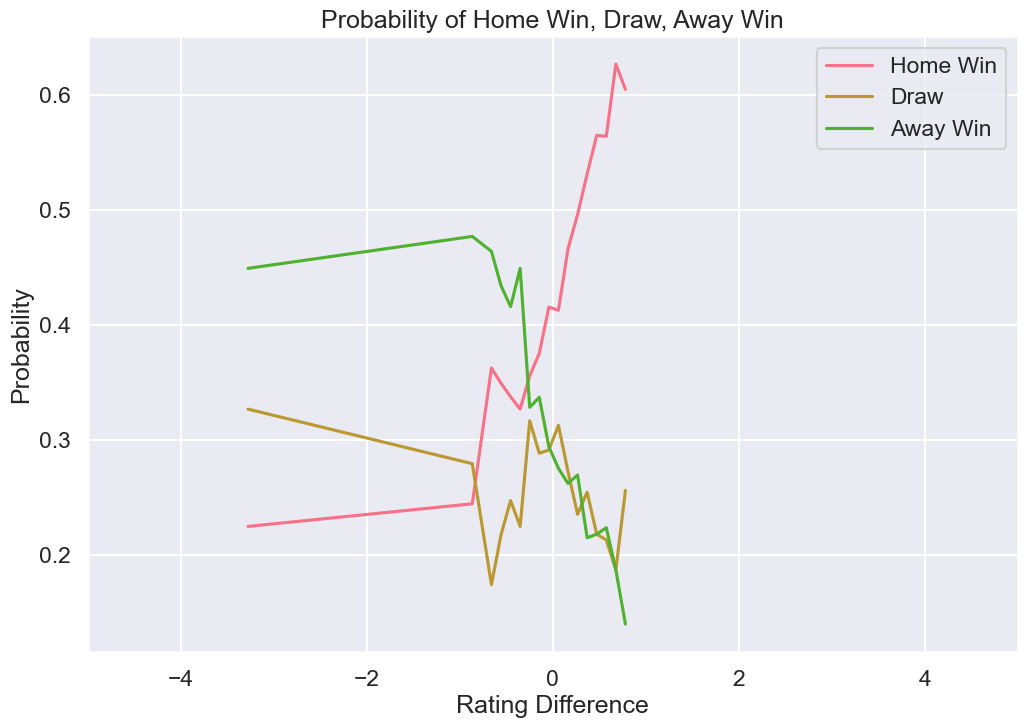

In [14]:
# visualize the relationship between the rating difference and the probability of the home team winning
#

plt.figure(figsize=(12, 8))
plt.plot(df_bins["BIN_LEFT"], df_bins["H_WINS"], label="Home Win")
plt.plot(df_bins["BIN_LEFT"], df_bins["DRAWS"], label="Draw")
plt.plot(df_bins["BIN_LEFT"], df_bins["A_WINS"], label="Away Win")
sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_palette("husl")

# center arount 0, add a title and axis labels
plt.xlim(-5, 5)
plt.title("Probability of Home Win, Draw, Away Win")
plt.xlabel("Rating Difference")
plt.ylabel("Probability")
plt.legend()
plt.show()